In [9]:
import pandas as pd
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import SGDOneClassSVM
from sklearn.ensemble import IsolationForest, VotingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score
from scipy.stats import entropy
from scipy.fft import rfft, rfftfreq, irfft

In [10]:
RANDOM_STATE = 0
data = pd.read_csv('../input/cardiospikecompetition/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60487 entries, 0 to 60486
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      60487 non-null  int64
 1   time    60487 non-null  int64
 2   x       60487 non-null  int64
 3   y       60487 non-null  int64
dtypes: int64(4)
memory usage: 1.8 MB


In [11]:
ids = data.id.unique()

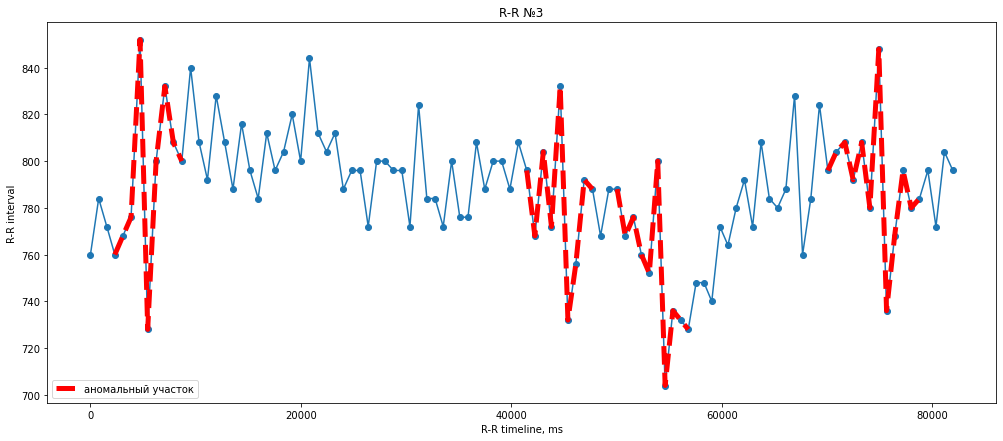

In [12]:
df = data.set_index('time').copy()
for rr_id in [ids[2]]:
    fig = plt.figure(figsize=(17,7))
    plt.title(f'R-R №{rr_id}')
    plt.plot(df[df.id == rr_id].x, '-o', zorder=1)
    df_anomaly = df[(df.id == rr_id)&(df.y == 1)].reset_index()
    df_anomaly['time-diff'] = df_anomaly.time.diff()
    split_indexes = df_anomaly[df_anomaly['time-diff'] > 1000].index
    split_indexes = list(split_indexes)
    split_indexes.append(0)
    split_indexes.sort()
    len_spl = len(split_indexes)
    for i in range(len_spl):
        if i == len_spl-1:
            mask = (df_anomaly.index >= split_indexes[i])
            plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '--',
                 label='аномальный участок', color='red', zorder=2, lw=5)
        else:
            mask = (df_anomaly.index >= split_indexes[i])&(df_anomaly.index < split_indexes[i+1])
            plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '--',
                     color='red', zorder=2, lw=5)
    plt.legend(loc='lower left')
    plt.xlabel('R-R timeline, ms')
    plt.ylabel('R-R interval')
    plt.show()

# Other anomaly detection algorithms implementation

## Полезные методы

In [13]:
def make_XY(df):
    """
    Подготовка признаков для обучения модели
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    X = df.drop(['y','id','time'], axis=1)
    y = df.y.to_numpy()

    scaler = StandardScaler().fit(X.to_numpy())
    X = scaler.transform(X.to_numpy())

    with open('scaler-isd-pipeline-10.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    print('scaler-isd-pipeline-10.pkl was saved in output directory')

    return X, y


def get_train_test_indexes(X,y):
    """
    X,y: numpy arrays with features and target
    return stratified indexes:
        train_indexes: indexes for train data
        test_indexes: indexes for test data
    """
    skf = StratifiedKFold()
    folds = dict()
    for i, (train_indexes, test_indexes) in enumerate(skf.split(X,y)):
        folds[i] = {
            'train_indexes': train_indexes,
            'test_indexes': test_indexes
        }
    return folds[0]['train_indexes'].tolist(), folds[0]['test_indexes'].tolist()


def plot_RR(rr_ids, data):
    """
    Рисует графики ритмограмм с разметкой аномальных участков
    rr_ids: список идентификаторов ритмограмм
    data: набор данных
    """
    df = data.set_index('time').copy()
    for rr_id in rr_ids:
        fig = plt.figure(figsize=(20,5))
        plt.title(f'R-R №{rr_id}')
        plt.plot(df[df.id == rr_id].x, '-o', zorder=1)
        df_anomaly = df[(df.id == rr_id)&(df.y == 1)].reset_index()
        df_anomaly['time-diff'] = df_anomaly.time.diff()
        split_indexes = df_anomaly[df_anomaly['time-diff'] > 1000].index
        split_indexes = list(split_indexes)
        split_indexes.append(0)
        split_indexes.sort()
        len_spl = len(split_indexes)
        for i in range(len_spl):
            if i == len_spl-1:
                mask = (df_anomaly.index >= split_indexes[i])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                     label='аномальный участок', color='red', zorder=2)
            else:
                mask = (df_anomaly.index >= split_indexes[i])&(df_anomaly.index < split_indexes[i+1])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                         color='red', zorder=2)
        plt.legend()
        plt.xlabel('R-R timeline, ms')
        plt.ylabel('R-R interval')
        plt.show()
        
        
def entropy1(labels, base=None):
    _, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)


def make_dataset(data):
    """
    Автоматизация подготовки датасета
    """
    df = data.copy()
    ids = df.id.unique()
    for rr_id in ids:
        mask = (df.id==rr_id) 
        
        DURATION = df.loc[mask].time.index[-1]-df.loc[mask].time.index[0]
        SAMPLE_RATE = len(df.loc[mask])/DURATION
        N = int(SAMPLE_RATE * DURATION)
        yf = rfft(df.loc[mask, 'x'])
        for j in range(10):
            yf[:j*2] = 0
            irr = irfft(yf)
            if len(df.loc[mask])-len(irr)==1:
                irr = np.append(irr, np.nan)
            df.loc[mask, f'fft_x_{j}'] = irr
            df.fillna(method='ffill', inplace=True)
            
        df.loc[mask, 'entropy'] = df[mask].x.rolling(20).apply(entropy1).fillna(method='bfill')
        df.loc[mask, 'x_diff'] = df[mask].x.diff()
        df.fillna(method='bfill', inplace=True)
        df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
        df.loc[mask, 'sign'] = np.sign(df.loc[mask, 'x_deviation_median'])
        df.loc[mask, 'sign_change'] = df.loc[mask, 'sign'].diff().fillna(method='bfill')
        df.drop(columns=['sign'], inplace=True)
        for i in range(1,8):
            # добавим в признаки 6 следующих точки
            df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
            # и 6 предыдущие точки
            df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
        df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
        df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
        df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
        df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
        df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
        df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
        df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values
        df.loc[mask, 'x-(x+5)'] = df[mask].x.values - df.loc[mask, 'x+5'].values
        df.loc[mask, 'x-(x-5)'] = df[mask].x.values - df.loc[mask, 'x-5'].values
        df.loc[mask, 'x-(x+6)'] = df[mask].x.values - df.loc[mask, 'x+6'].values
        df.loc[mask, 'x-(x-6)'] = df[mask].x.values - df.loc[mask, 'x-6'].values
        df.loc[mask, 'x-(x+7)'] = df[mask].x.values - df.loc[mask, 'x+7'].values
        df.loc[mask, 'x-(x-7)'] = df[mask].x.values - df.loc[mask, 'x-7'].values

        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
        
        df.loc[mask, 'entropy_x_deviation_median'] = df.loc[mask,'x_deviation_median'].rolling(20).apply(entropy1).fillna(method='bfill')

        df.loc[:,'x/(x-1)'] = df.x/df['x-1']
        df.loc[:,'x/(x+1)'] = df.x/df['x+1']
        df.loc[:,'x/(x-2)'] = df.x/df['x-2']
        df.loc[:,'x/(x+2)'] = df.x/df['x+2']
    return df

In [14]:
data = pd.read_csv('../input/cardiospikecompetition/train.csv')

index_to_drop = data[data.id==107].loc[17186:].index
data.drop(index=index_to_drop, inplace=True)
index_to_drop = data[data.id==108].loc[:19505].index
data.drop(index=index_to_drop, inplace=True)
index_to_drop = data[data.id==109].loc[19705:20351].index
data.drop(index=index_to_drop, inplace=True)
index_to_drop = data[data.id==127].loc[:24200].index
data.drop(index=index_to_drop, inplace=True)
  
df = make_dataset(data)

X,y = make_XY(df)

scaler-isd-pipeline-10.pkl was saved in output directory


## LGBM prerformance for comparation

In [15]:
lgbm = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
lgbm.fit(X, y)

LGBMClassifier(learning_rate=0.01, n_estimators=3860, random_state=0)

In [16]:
cv_result = cross_validate(lgbm, X, y, cv=StratifiedKFold(), scoring='f1', verbose=0, n_jobs=-1)

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

test_score: [0.8608828  0.75598086 0.74704635 0.82700157 0.79145038]
mean test_score = 0.7964723925963965


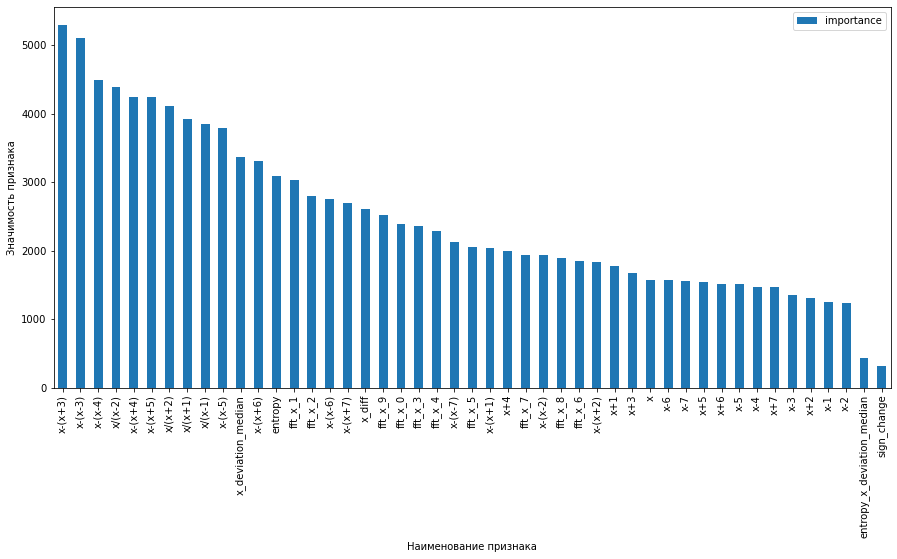

In [17]:
fe = pd.DataFrame()
fe['feature'] = df.drop(['y','id','time'], axis=1).columns.tolist()
fe['importance'] = lgbm.feature_importances_
fe.sort_values('importance', inplace=True, ascending=False)
fe.set_index('feature', inplace=True)
fe.plot(kind='bar', figsize=(15,7), label='Значимость признака')
plt.ylabel('Значимость признака')
plt.xlabel('Наименование признака')
plt.legend()
plt.show()

In [18]:
fe

,importance
feature,
x-(x+3),5290
x-(x-3),5105
x-(x-4),4490
x/(x-2),4386
x-(x+4),4237
x-(x+5),4234
x/(x+2),4111
x/(x+1),3921
x/(x-1),3853


In [19]:
fe.index.tolist()

['x-(x+3)',
 'x-(x-3)',
 'x-(x-4)',
 'x/(x-2)',
 'x-(x+4)',
 'x-(x+5)',
 'x/(x+2)',
 'x/(x+1)',
 'x/(x-1)',
 'x-(x-5)',
 'x_deviation_median',
 'x-(x+6)',
 'entropy',
 'fft_x_1',
 'fft_x_2',
 'x-(x-6)',
 'x-(x+7)',
 'x_diff',
 'fft_x_9',
 'fft_x_0',
 'fft_x_3',
 'fft_x_4',
 'x-(x-7)',
 'fft_x_5',
 'x-(x+1)',
 'x+4',
 'fft_x_7',
 'x-(x-2)',
 'fft_x_8',
 'fft_x_6',
 'x-(x+2)',
 'x+1',
 'x+3',
 'x',
 'x-6',
 'x-7',
 'x+5',
 'x+6',
 'x-5',
 'x-4',
 'x+7',
 'x-3',
 'x+2',
 'x-1',
 'x-2',
 'entropy_x_deviation_median',
 'sign_change']

## One-class SVM (SGD) performance
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html#sklearn.linear_model.SGDOneClassSVM

In [20]:
y.mean().round(2)

0.16

In [21]:
svm = SGDOneClassSVM(
    nu=y.mean().round(2), 
    random_state=RANDOM_STATE,
    shuffle=False
)
svm.fit(X)

SGDOneClassSVM(nu=0.16, random_state=0, shuffle=False)

svm выдаёт значения -1 при аномалии и 1 при норме, соответственно заменю в настоящем y 0 на 1, а 1 на -1, чтобы нормально прошла кросс-валидация

In [22]:
y_ = np.where(y == 1, -1, y)
y_ = np.where(y_ == 0, 1, y_)
y_

array([1, 1, 1, ..., 1, 1, 1])

In [23]:
cv_result = cross_validate(svm, X, y_, cv=StratifiedKFold(), scoring='f1', verbose=0, n_jobs=-1)

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

test_score: [0.8713892  0.8366263  0.74115838 0.66323106 0.74420633]
mean test_score = 0.7713222552028232


результат похуже, попробую подобрать nu

In [24]:
nus = []
f1_scores = []
for nu_ in range(5, 30):
    nus.append(nu_/100)
    svm = SGDOneClassSVM(
        nu=nu_/100, 
        random_state=RANDOM_STATE,
        shuffle=False
    )
    svm.fit(X)
    cv_result = cross_validate(svm, X, y_, cv=StratifiedKFold(), scoring='f1', verbose=0, n_jobs=-1)
    f1_scores.append(cv_result['test_score'].mean())

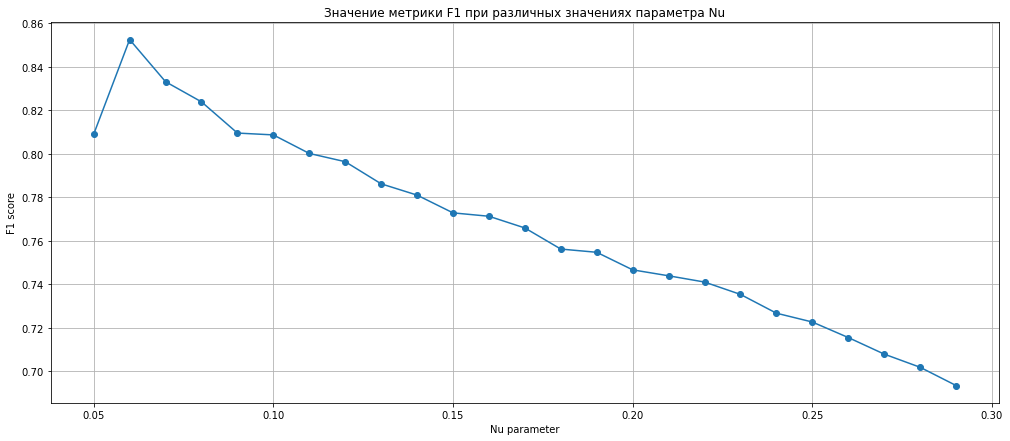

In [25]:
out = pd.DataFrame()
out['nu'] = nus
out['f1'] = f1_scores

out.plot(x='nu', y='f1', figsize=(17,7), marker='o', grid=True, legend=False)
plt.xlabel('Nu parameter')
plt.ylabel('F1 score')
plt.title('Значение метрики F1 при различных значениях параметра Nu')
plt.show()

In [26]:
nus[np.argmax(f1_scores)], np.max(f1_scores)

(0.06, 0.8525876002644681)

In [27]:
svm = SGDOneClassSVM(
    nu=0.06, 
    random_state=RANDOM_STATE,
    shuffle=False
)
svm.fit(X)

SGDOneClassSVM(nu=0.06, random_state=0, shuffle=False)

In [28]:
cv_result = cross_validate(svm, X, y_, cv=StratifiedKFold(), scoring='f1', verbose=0, n_jobs=-1)

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

test_score: [0.89194303 0.87251605 0.85248757 0.81015732 0.83583402]
mean test_score = 0.8525876002644681


## Isolation Forest performance
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

In [29]:
isf = IsolationForest(
    random_state=RANDOM_STATE,
    n_jobs=-1
)
isf.fit(X)

IsolationForest(n_jobs=-1, random_state=0)

isf выдаёт значения -1 при аномалии и 1 при норме, соответственно заменю в настоящем y 0 на 1, а 1 на -1, чтобы нормально прошла кросс-валидация

In [30]:
y_ = np.where(y == 1, -1, y)
y_ = np.where(y_ == 0, 1, y_)
y_

array([1, 1, 1, ..., 1, 1, 1])

In [31]:
cv_result = cross_validate(isf, X, y_, cv=StratifiedKFold(), scoring='f1', verbose=0, n_jobs=-1)

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

test_score: [0.88985136 0.90189396 0.86904643 0.79594017 0.81486543]
mean test_score = 0.854319470117035


ещё лучше, чем у svm!

# Voiting performance

In [36]:
kf = StratifiedKFold()

In [38]:
lgbm_preds = []
svm_preds = []
isf_preds = []

for train, test in kf.split(X, y):
    # LGBM
    lgbm = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
    lgbm.fit(X[train], y[train])
    lgbm_preds.append(f1_score(y[test], lgbm.predict(X[test])))
    
    # y_
    y_ = np.where(y[test] == 1, -1, y[test])
    y_ = np.where(y_ == 0, 1, y_)

    # SVM
    svm = SGDOneClassSVM(
        nu=y[train].mean().round(2), 
        random_state=RANDOM_STATE,
        shuffle=False
    )
    svm.fit(X[train])
    svm_preds.append(f1_score(y_, svm.predict(X[test])))

    # Isolation Forest
    isf = IsolationForest(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    isf.fit(X[train])
    isf_preds.append(f1_score(y_, isf.predict(X[test])))

In [39]:
res = pd.DataFrame()
res['lgbm'] = lgbm_preds
res['svm'] = svm_preds
res['isf'] = isf_preds
res

,lgbm,svm,isf
0,0.860883,0.871389,0.889851
1,0.755981,0.836626,0.901894
2,0.747046,0.741158,0.869046
3,0.827002,0.663231,0.795940
4,0.791450,0.744206,0.814865


In [49]:
res = pd.DataFrame()
res['lgbm'] = [0,1,0]
res['svm'] = [0,1,1]
res['isf'] = [1,1,1]
display(res)
display(res.mode(axis=1))
res.mode(axis=1).values.ravel()

,lgbm,svm,isf
0,0,0,1
1,1,1,1
2,0,1,1


,0
0,0
1,1
2,1


array([0, 1, 1])

In [65]:
scores_w = []
scores_b = []

for train, test in kf.split(X, y):
    # LGBM
    lgbm = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
    lgbm.fit(X[train], y[train])
    lgbm_preds = lgbm.predict(X[test])

    # SVM
    svm = SGDOneClassSVM(
        nu=y[train].mean().round(2), 
        random_state=RANDOM_STATE,
        shuffle=False
    )
    svm.fit(X[train])
    pred = svm.predict(X[test])
    y_ = np.where(pred == 1, 0, pred)
    svm_preds = np.where(y_ == -1, 1, y_)
    

    # Isolation Forest
    isf = IsolationForest(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    isf.fit(X[train])
    pred = isf.predict(X[test])
    y_ = np.where(pred == 1, 0, pred)
    isf_preds = np.where(y_ == -1, 1, y_)

    # voiting
    res = pd.DataFrame()
    res['lgbm'] = lgbm_preds
    res['svm'] = svm_preds
    res['isf'] = isf_preds
    voiting_predictions = res.mode(axis=1).values.ravel()

    scores_w.append(f1_score(y[test], voiting_predictions, average='weighted'))
    scores_b.append(f1_score(y[test], voiting_predictions))

In [66]:
print('test_score:', scores_w)
print('mean test_score =', np.mean(scores_w).round(4))

test_score: [0.7925969976764876, 0.8038817077243434, 0.7788753996928076, 0.7154190697586543, 0.8909964985407557]
mean test_score = 0.7964


In [67]:
pd.to_pickle(isf,'isf-model.pkl')